In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.spatial.transform import Rotation as rot
from scipy.optimize import minimize

# Alternative approach

## The spherical coordinate system

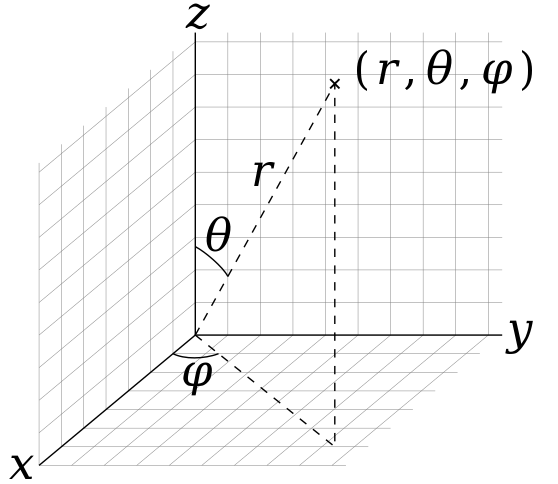

Spherical coordinates $(r, \theta, \varphi)$ as used in physics (ISO 80000-2:2019), being $r$ the radial distance (distance to origin), polar angle $\theta$ (theta) (angle with respect to polar/zenith z-axis), and azimuthal angle $\varphi$ (phi) (angle of rotation from the initial meridian plane).

> **Important note**: the angles $\theta$ and $\phi$ in Asimov et al. (2006) are interchanged with respect to the convention used in physics (see https://en.wikipedia.org/wiki/Spherical_coordinate_system). To avoid confusion, perhaps it would be a good idea to rename them (alpha and beta?) since strictly speaking they are angles with respect to crystallographic axes, not to the reference system (although later we will make them coincide).

## Set the FTIR reference frame

To estimate the orientation of the crystals in the FTIR we will have to consider the following reference frames to establish a consistent coordinate frame:

- the microscope stage/sample pair
- the position of the reference transmittance envelope with respect to the reference system of the microscope
- the position of the crystalline elements (axes, planes, etc.) with respect to the transmitance envelope

We start by defining that all coordinate systems used will be right handed, which also implies the right hand rule for the sense of rotations (positive rotation counter-clockwise). To determine the full orientation of a crystal, it is necessary to define a Cartesian reference frame for the crystal lattice. The unit cell is commonly described using three lengths, $a$, $b$ and $c$ and three angles $α$, $β$, $γ$ as depicted inthe figure below. For a general case:

- $a$, $b$ and $c$ form a right handed set.
- $c$ is parallel to the $z$ axis.
- $b$ lies in the $y$-$z$ plane, at an angle $α$ to $c$
- $a$ is pointed such that it is an angle $β$ to $c$ and $γ$ to $b$

![EBSD_ref_frame](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/EBSD_unit_cell_convention.png)

As olivine is orthorhombic, the axes defining the olivine unit cell are perpendicular to each other and thus the $c$-axis is parallel to $z$, the $a$-axis is parallel to $x$, and the $b$-axis is parallel to $y$. With this frame of reference, the transmittance figure in our coordinate system is as follows.


In [25]:
def Tvalues(trans, theta, phi):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006) for a
    especific wavelength ignoring the sample thickness (i.e. =1).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    theta : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    phi : int or float between 0 and 2*pi
        angle respect to the a-axis in radians

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(phi)**2 * np.sin(theta)**2 + \
           Tb * np.sin(phi)**2 * np.sin(theta)**2 + \
           Tc * np.cos(theta)**2


def sph2cart(r, phi, theta=np.deg2rad(90)):
    """ Convert from spherical/polar (magnitude, thetha, phi) to
    cartesian coordinates. Phi and theta angles are as used in
    physics (ISO 80000-2:2019) and in radians. If theta is not given,
    the point is assumed to lie on the XY plane.

    Parameters
    ----------
    r : int, float or array
        radial distance (magnitud of the vector)
    phi : int, float or array with values between 0 and 2*pi
        azimuth angle respect to the x-axis direction in radians
    theta : int, float or array with values between 0 and pi/2,
        polar angle respect to the zenith (z) direction in radians
        optional
    
    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the cartesian x, y, and z coordinates
    """
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return np.around(x, decimals=6), np.around(y, decimals=6), np.around(z, decimals=6)


In [30]:
# check that a phi angle of 0 and a theta of 90 is the coordinates (1,0,0)
sph2cart(1, phi=0)

(1.0, 0.0, 0.0)

In [31]:
# check that a phi angle of 90 and a theta of 90 is the coordinates (0,1,0)
sph2cart(1, phi=np.deg2rad(90))

(0.0, 1.0, 0.0)

In [32]:
# check that at any phi angle and a theta of 0 the coordinates are (0,0,1)
sph2cart(1, phi=np.deg2rad(45), theta=0), sph2cart(1, phi=np.deg2rad(15), theta=0)

((0.0, 0.0, 1.0), (0.0, 0.0, 1.0))

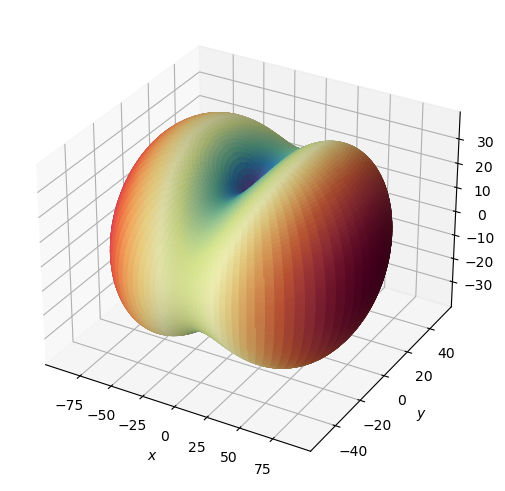

In [33]:
# generate spherical/polar coordinates
phi = np.linspace(0, 2*np.pi, 100)
theta = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # phi = arcos(1 - 2x) in this case np.linspace goes from 0 to 1 (not pi)!*
theta, phi = np.meshgrid(theta, phi)

# estimate T values
T = Tvalues(trans=(90, 50, 20), theta=theta, phi=phi)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(T, phi, theta)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')


This would be the reference transmittance envelope for olivine for a specific thickness and wavelength. Its use is as follows: any transmittance figure we determine from an olivine crystal has to be rotated to this position in order to estimate the crystallographic orientation of the crystal in our reference frame.

Given these premises, the approach to determine the crystallographic orientation from a few transmittance measurements is as follows.

## Step 1

Estimate the transmission values on the microscope at three different angles respect to the polarization direction. Accordingly we get two different paramenters in each measure

$$
(\alpha, T)
$$

where $\alpha$ is the angle in degrees between the polarizer (E-vector) and a reference within the sample (for example the large side of the sample or whatever suits us) and $T$ the transmission. In practice we will measure:

$$
(0, T_1) \newline (45, T_2) \newline (90, T_3)
$$

In our 3d cartesian reference frame we will be measuring points within the plane $XY$ represented by the microscope stage and defined by the normal vector (0, 0, 1) and the reference point (0, 0, 0) that corresponds with the center of the microscope. These values can be converted to cartesian coordinates as follows assuming that $\alpha$ is provided in radians and that the direction of polarization is parallel to $x$.

$$
x = T \cdot cos(\alpha) \newline
y = T \cdot sin(\alpha) \newline
z = 0
$$

For this we can use the ``sph2cart()`` function assuming that $\alpha = \varphi$ and that $\theta$ takes an agle of 90 degrees (the default option)

for example:

In [35]:
sph2cart(35, phi=np.deg2rad(45)), sph2cart(60, phi=np.deg2rad(90))

((24.748737, 24.748737, 0.0), (0.0, 60.0, 0.0))

## Step 2

Once these points are converted to cartesian coordinates, we need to check if they lie on the surface of our transmission reference figure and, if not, rotate the points (using Euler angles as input) and repeat until all the points lie on the transmission surface. For this we need to:

- convert the cartesian coordinates to polar coordinates.
- test whether the points minimize the error in the transmission equation. If all points lie in the surface within an error, we are done. If not rotate the datapoints and repeat exploring the Euler space until the transmission equation minimizes to zero.

The simplified transmission equation as a function of $\theta$, $\phi$ is:

$$
T = T_a \cdot cos^2\varphi sin^2\theta + T_b \cdot sin^2\varphi sin^2\theta + T_c \cdot cos^2\theta
$$

as we know the $T_a, T_b, T_c$ values and we provide $T$, $\theta$, and $\phi$ from our measures we need to ensure that

$$
(T_a \cdot cos^2\varphi sin^2\theta + T_b \cdot sin^2\varphi sin^2\theta + T_c \cdot cos^2\theta) - T = 0
$$

To convert from cartesian (SO3 space) to polar coordinates is as follows:

$$
r = \sqrt(x^2 + y^2 + z^2) \newline
\theta = arccos(z / r) \newline  
\phi = arctan2(x, y)
$$

where $r$ will be our $T$.

For this, we will need functions to convert Cartesian to spherical coordinates, rotate points in space, and minimisation.



In [42]:
def cart2sph(x, y, z):
    """Converts from 3D cartesian to spherical coordinates.

    Parameters
    ----------
    x : int, float or array
        The x-coordinate(s) in Cartesian space.
    y : int, float or array
        The y-coordinate(s) in Cartesian space.
    z : int, float or array
        The z-coordinate(s) in Cartesian space.

    Returns
    -------
    tuple of floats
        A tuple containing the polar coordinates (r, theta, phi) of the input Cartesian point,
        where r is the distance from the origin to the point, theta is the polar angle from the
        positive z-axis, and phi is the azimuthal angle from the positive x-axis (ISO 80000-2:2019).
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)  # arctan2 calculates the arctangent with the correct sign to handle all quadrants

    return (r, phi, theta)


def rotate(coordinates, euler_ang):
    """ Rotate points in 3D cartesian space using the Bunge convention
    in degrees with intrinsic rotation. This is just a wrapper for the
    r.from_euler() Scipy method for convenience

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = rot.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]


## Test functions above

In [37]:
cart2sph(1, 1, 1)

(1.7320508075688772, 0.9553166181245092, 0.7853981633974483)

In [38]:
np.rad2deg(0.9553166181245092), np.rad2deg(0.7853981633974483)

(54.735610317245346, 45.0)

In [43]:
# check that the functions are correct
T, phi, theta = cart2sph(1, 1, 1)
sph2cart(T, phi, theta)

(1.0, 1.0, 1.0)

## Design the minimization procedure

To test the procedure we need a function that estimates the $T$ values as a function of the orientation of the crystal and the angle $\alpha$.

In [ ]:
# starting points, points are: (alpha, T)
point_a = (np.deg2rad(0), 50)
point_b = (np.deg2rad(45), 45)
point_c = (np.deg2rad(90), 60)

not checked yet!

In [ ]:
def check_points_on_surface(points, trans, tol=1e-6):
    """
    Given a set of points in 3D space, determine if they fall on the surface
    defined by the function T. If the points do not fall on the surface,
    apply a rotation to the points and check again until the points fall on
    the surface. Return the Euler angles that rotate the points to the surface.

    Parameters
    ----------
    points : tuple of size 3
        a tuple containing the cartesian coordinates of the points
        in the form (x, y, z). Each element can be a scalar or an array.
    trans : tuple of size 3
        tuple containing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    tol : float
        tolerance for determining if a point is on the surface

    Returns
    -------
    tuple of size 3
        tuple containing the Euler angles in degrees for rotating
        the points to the surface

    """
    def func(euler_ang, points, trans):
        """Returns the square of the difference between the values of T at the
        given points and the expected value of T for the given transmission values
        and angles of rotation."""
        rotated_points = rotate(points, euler_ang)
        T_values = T(trans, rotated_points[2], np.arctan2(rotated_points[1], rotated_points[0]))
        return np.sum((T_values - 1)**2)
    
    bounds = [(0, 90), (0, 180), (0, 90)]
    euler_ang_guess = (0, 0, 0)
    result = minimize(fun=func, args=(points, trans), x0=euler_ang_guess, bounds=bounds)
    euler_angles = result.x
    while result.fun > tol:
        points = rotate(points, euler_angles)
        result = minimize(fun=func, args=(points, trans), x0=euler_ang_guess, bounds=bounds)
        euler_angles = result.x
    return tuple(euler_angles)